In [ ]:
import os

from dotenv import load_dotenv

load_dotenv(os.path.join("..", ".env"), override=True)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Deep Agent for Research

## Overview 

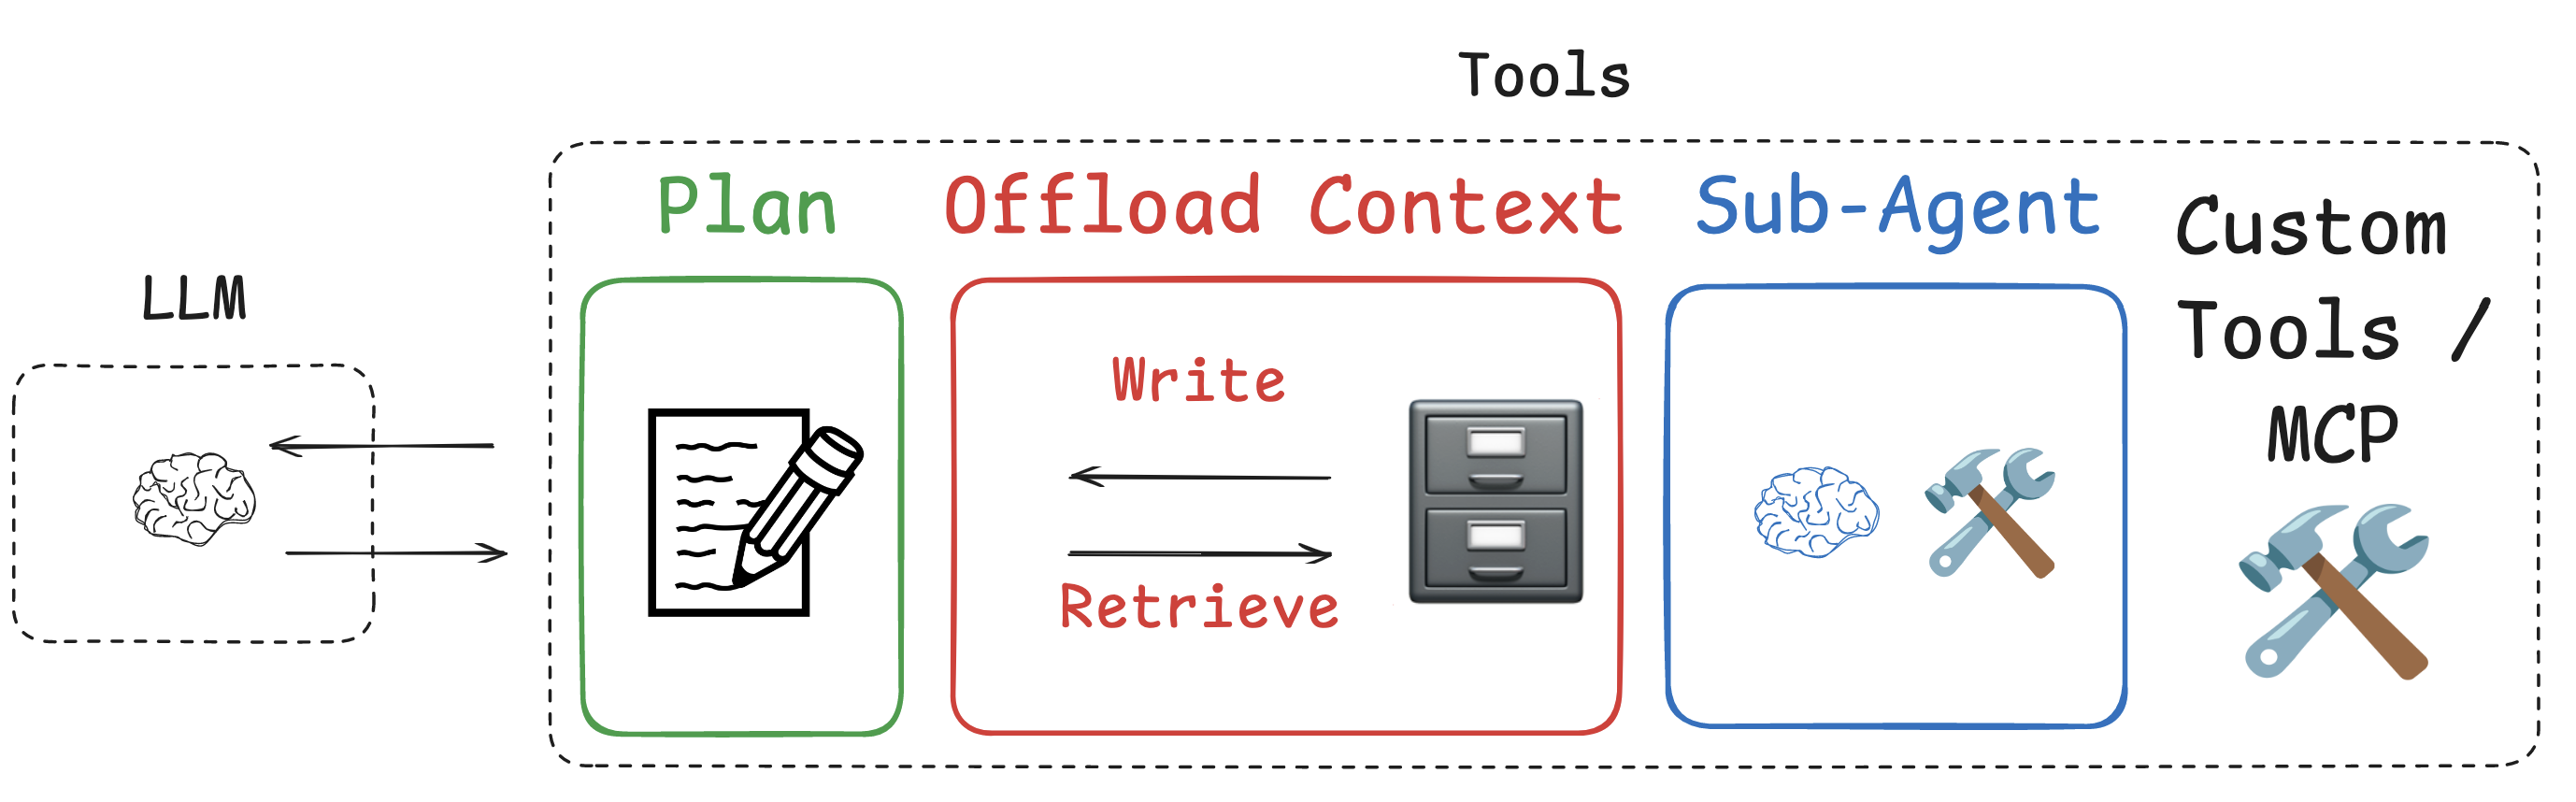

Now, we can put everything we have learned together:

* We will use **TODOs** to keep track of tasks. 
* We will use **files** to store raw tool call results. 
* We will **delegate research tasks to sub-agents** for context isolation. 

## Search Tool 

We'll build a search tool that offloads raw contents to files and returns only a summary to the agent. This is a common pattern for long-running agent trajectories, [as we've seen with Manus](https://manus.im/blog/Context-Engineering-for-AI-Agents-Lessons-from-Building-Manus)! 

### Core Components

1. **Search Execution (`run_tavily_search`)**: Performs the actual web search using Tavily API with configurable parameters for results count and topic filtering.

2. **Content Summarization (`summarize_webpage_content`)**: Uses a lightweight model (GPT-4o-mini) to generate structured summaries of webpage content, producing both a descriptive filename and key learnings summary.

3. **Result Processing (`process_search_results`)**: Fetches full webpage content via HTTP, converts HTML to markdown using `markdownify`, and generates summaries for each result.

4. **Context Offloading (`tavily_search` tool)**: The main tool that:
   - Executes search and processes results
   - Saves full content to files in agent state (context offloading)
   - Returns only minimal summaries to the agent (prevents context spam)
   - Uses LangGraph `Command` to update both files and messages

5. **Strategic Thinking (`think_tool`)**: Provides a structured reflection mechanism for agents to analyze findings, assess gaps, and plan next steps in their research workflow.

This architecture solves the token efficiency problem by storing detailed search results in files while keeping the agent's working context minimal and focused.

In [1]:
%%writefile ../src/deep_agents_from_scratch/research_tools.py

"""Research Tools.

This module provides search and content processing utilities for the research agent,
including web search capabilities and content summarization tools.
"""

from datetime import datetime

import httpx
from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, ToolMessage
from langchain_core.tools import InjectedToolArg, InjectedToolCallId, tool
from langgraph.prebuilt import InjectedState
from langgraph.types import Command
from markdownify import markdownify
from pydantic import BaseModel, Field
from tavily import TavilyClient
from typing_extensions import Annotated, Literal

from deep_agents_from_scratch.prompts import SUMMARIZE_WEB_SEARCH
from deep_agents_from_scratch.state import DeepAgentState

# Summarization model 
summarization_model = init_chat_model(model="openai:gpt-4o-mini")
tavily_client = TavilyClient()

class Summary(BaseModel):
    """Schema for webpage content summarization."""
    filename: str = Field(description="Name of the file to store.")
    summary: str = Field(description="Key learnings from the webpage.")

def get_today_str() -> str:
    """Get current date in a human-readable format."""
    return datetime.now().strftime("%a %b %-d, %Y")

def run_tavily_search(
    search_query: str, 
    max_results: int = 1, 
    topic: Literal["general", "news", "finance"] = "general", 
    include_raw_content: bool = True, 
) -> dict:
    """Perform search using Tavily API for a single query.

    Args:
        search_query: Search query to execute
        max_results: Maximum number of results per query
        topic: Topic filter for search results
        include_raw_content: Whether to include raw webpage content

    Returns:
        Search results dictionary
    """
    result = tavily_client.search(
        search_query,
        max_results=max_results,
        include_raw_content=include_raw_content,
        topic=topic
    )

    return result

def summarize_webpage_content(webpage_content: str) -> Summary:
    """Summarize webpage content using the configured summarization model.
    
    Args:
        webpage_content: Raw webpage content to summarize
        
    Returns:
        Summary object with filename and summary
    """
    try:
        # Set up structured output model for summarization
        structured_model = summarization_model.with_structured_output(Summary)
        
        # Generate summary
        summary_and_filename = structured_model.invoke([
            HumanMessage(content=SUMMARIZE_WEB_SEARCH.format(
                webpage_content=webpage_content, 
                date=get_today_str()
            ))
        ])
        
        return summary_and_filename
        
    except Exception:
        # Return a basic summary object on failure
        return Summary(
            filename="search_result.md",
            summary=webpage_content[:1000] + "..." if len(webpage_content) > 1000 else webpage_content
        )

def process_search_results(results: dict) -> list[dict]:
    """Process search results by summarizing content where available.
    
    Args:
        results: Tavily search results dictionary
        
    Returns:
        List of processed results with summaries
    """
    processed_results = []

    # Create a client for HTTP requests
    HTTPX_CLIENT = httpx.Client()
    
    for result in results.get('results', []):
        
        # Get url 
        url = result['url']
        
        # Read url
        response = HTTPX_CLIENT.get(url)
        response.raise_for_status()

        if response.status_code == 200:
            # Convert HTML to markdown
            raw_content = markdownify(response.text)
            summary_obj = summarize_webpage_content(raw_content)
        else:
            # Use Tavily's generated summary
            raw_content = result.get('raw_content', '')
            summary_obj = Summary(
                filename=None,
                summary=result.get('content', 'Error reading URL; try another search.')
            )
        
        processed_results.append({
            'url': result['url'],
            'title': result['title'],
            'summary': summary_obj.summary,
            'filename': summary_obj.filename,
            'raw_content': raw_content,
        })
    
    return processed_results

@tool(parse_docstring=True)
def tavily_search(
    query: str,
    state: Annotated[DeepAgentState, InjectedState],
    tool_call_id: Annotated[str, InjectedToolCallId],
    max_results: Annotated[int, InjectedToolArg] = 1,
    topic: Annotated[Literal["general", "news", "finance"], InjectedToolArg] = "general",
) -> Command:
    """Search web and save detailed results to files while returning minimal context.

    Performs web search and saves full content to files for context offloading.
    Returns only essential information to help the agent decide on next steps.

    Args:
        query: Search query to execute
        state: Injected agent state for file storage
        tool_call_id: Injected tool call identifier
        max_results: Maximum number of results to return (default: 1)
        topic: Topic filter - 'general', 'news', or 'finance' (default: 'general')

    Returns:
        Command that saves full results to files and provides minimal summary
    """
    # Execute search
    search_results = run_tavily_search(
        query,
        max_results=max_results,
        topic=topic,
        include_raw_content=True,
    ) 

    # Process and summarize results
    processed_results = process_search_results(search_results)
    
    # Save each result to a file and prepare summary
    files = state.get("files", {})
    saved_files = []
    summaries = []
    
    for i, result in enumerate(processed_results):
        # Use the AI-generated filename from summarization
        filename = result['filename']
        
        # Create file content with full details
        file_content = f"""# Search Result: {result['title']}

**URL:** {result['url']}
**Query:** {query}
**Date:** {get_today_str()}

## Summary
{result['summary']}

## Raw Content
{result['raw_content'] if result['raw_content'] else 'No raw content available'}
"""
        
        files[filename] = file_content
        saved_files.append(filename)
        # Use only first 80 chars for very concise context
        summaries.append(f"- {filename}: {result['summary']}...")
    
    # Create minimal summary for tool message - focus on what was collected
    summary_text = f"""🔍 Found {len(processed_results)} result(s) for '{query}':

{chr(10).join(summaries)}

Files: {', '.join(saved_files)}
💡 Use read_file() to access full details when needed."""

    return Command(
        update={
            "files": files,
            "messages": [
                ToolMessage(summary_text, tool_call_id=tool_call_id)
            ],
        }
    )

@tool(parse_docstring=True)
def think_tool(reflection: str) -> str:
    """Tool for strategic reflection on research progress and decision-making.

    Use this tool after each search to analyze results and plan next steps systematically.
    This creates a deliberate pause in the research workflow for quality decision-making.

    When to use:
    - After receiving search results: What key information did I find?
    - Before deciding next steps: Do I have enough to answer comprehensively?
    - When assessing research gaps: What specific information am I still missing?
    - Before concluding research: Can I provide a complete answer now?

    Reflection should address:
    1. Analysis of current findings - What concrete information have I gathered?
    2. Gap assessment - What crucial information is still missing?
    3. Quality evaluation - Do I have sufficient evidence/examples for a good answer?
    4. Strategic decision - Should I continue searching or provide my answer?

    Args:
        reflection: Your detailed reflection on research progress, findings, gaps, and next steps

    Returns:
        Confirmation that reflection was recorded for decision-making
    """
    return f"Reflection recorded: {reflection}"

Overwriting ../src/deep_agents_from_scratch/research_tools.py


## Deep Agent

Now, we can just apply all of our prior learnings: 

* We'll give the researcher a `think_tool` and our `search_tool` above.
* We'll give our parent agent file tools, a `think_tool`, and a `task` tool. 

In [3]:
from datetime import datetime

from IPython.display import Image, display
from langchain.chat_models import init_chat_model
from langgraph.prebuilt import create_react_agent
from utils import show_prompt

from deep_agents_from_scratch.file_tools import ls, read_file, write_file
from deep_agents_from_scratch.prompts import (
    FILE_USAGE_INSTRUCTIONS,
    RESEARCHER_INSTRUCTIONS,
    SUBAGENT_USAGE_INSTRUCTIONS,
    TODO_USAGE_INSTRUCTIONS,
)
from deep_agents_from_scratch.research_tools import tavily_search, think_tool
from deep_agents_from_scratch.state import DeepAgentState
from deep_agents_from_scratch.task_tool import _create_task_tool
from deep_agents_from_scratch.todo_tools import write_todos

# Create agent using create_react_agent directly
model = init_chat_model(model="anthropic:claude-sonnet-4-20250514", temperature=0.0)

# Limits
max_concurrent_research_units = 3
max_researcher_iterations = 3

# Tools
sub_agent_tools = [tavily_search, think_tool]
built_in_tools = [ls, read_file, write_file, write_todos, think_tool]

# Create research sub-agent
research_sub_agent = {
    "name": "research-agent",
    "description": "Delegate research to the sub-agent researcher. Only give this researcher one topic at a time.",
    "prompt": RESEARCHER_INSTRUCTIONS,
    "tools": ["tavily_search", "think_tool"],
}

# Create task tool to delegate tasks to sub-agents
task_tool = _create_task_tool(
    sub_agent_tools, [research_sub_agent], model, DeepAgentState
)

delegation_tools = [task_tool]
all_tools = sub_agent_tools + built_in_tools + delegation_tools

# Build prompt
SUBAGENT_INSTRUCTIONS = SUBAGENT_USAGE_INSTRUCTIONS.format(
    max_concurrent_research_units=max_concurrent_research_units,
    max_researcher_iterations=max_researcher_iterations,
    date=datetime.now().strftime("%a %b %-d, %Y"),
)

In [4]:
INSTRUCTIONS = (
    "# TODO MANAGEMENT\n"
    + TODO_USAGE_INSTRUCTIONS
    + "\n\n"
    + "=" * 80
    + "\n\n"
    + "# FILE SYSTEM USAGE\n"
    + FILE_USAGE_INSTRUCTIONS
    + "\n\n"
    + "=" * 80
    + "\n\n"
    + "# SUB-AGENT DELEGATION\n"
    + SUBAGENT_INSTRUCTIONS
)

show_prompt(INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  # TODO MANAGEMENT                                                                                              │
│  Based upon the user's request:                                                                                 │
│  │                                                                                                              │
│  1. Use the write_todos tool to create TODO at the start of a user request, per the tool description.           │
│  2. After you accomplish a TODO, use the read_todos to read the TODOs in order to remind yourself of the plan.  │
│  3. Reflect on what you've done and the TODO.                                                                   │
│  4. Mark you task as completed, and proceed to the next TODO.                                                   │
│  5. Continue this process until you have completed all TODOs.                                                   │
│                                                                                                                 │
│  IMPORTANT: Always create a research plan of TODOs and conduct research following the above guidelines for ANY  │
│  user request.                                                                                                  │
│  IMPORTANT: Aim to batch research tasks into a *single TODO* in order to minimize the number of TODOs you have  │
│  to keep track of.                                                                                              │
│                                                                                                                 │
│                                                                                                                 │
│  ================================================================================                               │
│                                                                                                                 │
│  # FILE SYSTEM USAGE                                                                                            │
│  You have access to a virtual file system to help you retain and save context.                                  │
│                                                                                                                 │
│  ## Workflow Process                                                                                            │
│  1. **Orient**: Use ls() to see existing files before starting work                                             │
│  2. **Save**: Use write_file() to store the user's request so that we can keep it for later                     │
│  3. **Research**: Proceed with research. The search tool will write files.                                      │
│  4. **Read**: Once you are satisfied with the collected sources, read the files and use them to answer the      │
│  user's question directly.                                                                                      │
│                                                                                                                 │
│                                                                                                                 │
│  ================================================================================                               │
│                                                                                                                 │
│  # SUB-AGENT DELEGATION                                                                                         │
│  You can delegate tasks to sub-agents.                                                                          │
│                                                       

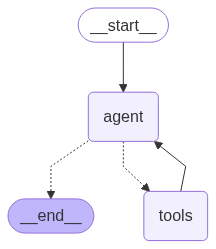

In [5]:
# Create agent
agent = create_react_agent(
    model, all_tools, prompt=INSTRUCTIONS, state_schema=DeepAgentState
)

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [26]:
from utils import format_messages

result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "Give me an overview of Model Context Protocol (MCP).",
            }
        ],
    }
)

format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Give me an overview of Model Context Protocol (MCP).                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I'll help you get a comprehensive overview of Model Context Protocol (MCP). Let me start by creating a research │
│ plan and then gathering information.                                                                            │
│                                                                                                                 │
│ 🔧 Tool Call: ls                                                                                                │
│    Args: {}                                                                                                     │
│    ID: toolu_01WywvBDKSQWuLmqxqoEnJFj                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_file                                                                                        │
│    Args: {                                                                                                      │
│   "file_path": "user_request.md",                                                                               │
│   "content": "# User Request\n\nGive me an overview of Model Context Protocol (MCP).\n\n## Research             │
│ Goal\nProvide a comprehensive overview covering:\n- What MCP is and its purpose\n- Key features and             │
│ capabilities\n- How it works technically\n- Use cases and applications\n- Current status and adoption"          │
│ }                                                                                                               │
│    ID: toolu_018xtgNuKMtMJBSRgRtiPVD7                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated file user_request.md                                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Research Model Context Protocol (MCP) - definition, purpose, technical details, features, use │
│ cases, and current status",                                                                                     │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Analyze research findings and provide comprehensive overview to user",                        │
│       "status": "pending"                                                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: toolu_01ArBCm2KvAmEU4GjFKuKj1Y                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research Model Context Protocol (MCP) - definition, purpose, technical       │
│ details, features, use cases, and current status', 'status': 'pending'}, {'content': 'Analyze research findings │
│ and provide comprehensive overview to user', 'status': 'pending'}]                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Now let me delegate the research task to gather comprehensive information about MCP.                            │
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "description": "Research Model Context Protocol (MCP) comprehensively. I need to understand: 1) What MCP is   │
│ and its fundamental purpose, 2) Key technical features and capabilities, 3) How it works architecturally, 4)    │
│ Main use cases and applications, 5) Current development status, adoption, and who created it. Please gather     │
│ detailed information from official sources, documentation, and recent developments.",                           │
│   "subagent_type": "research-agent"                                                                             │
│ }                                                                                                               │
│    ID: toolu_01FFbyBfvVmnLvZS7zUhLuri                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Based on my comprehensive research, here's what I found about the Model Context Protocol (MCP):                 │
│                                                                                                                 │
│ ## 1. What MCP Is and Its Fundamental Purpose                                                                   │
│                                                                                                                 │
│ The **Model Context Protocol (MCP)** is an open-standard framework introduced by Anthropic in November 2024.    │
│ Its fundamental purpose is to **standardize how AI systems integrate and share data with external tools and     │
│ data sources**. MCP aims to simplify the complex process of connecting AI applications to various external      │
│ systems, enhancing interoperability and making data access more seamless across different platforms.            │
│                                                                                                                 │
│ ## 2. Key Technical Features and Capabilities                                                                   │
│                                                                                                                 │
│ MCP offers several important technical features:                                                                │
│                                                                                                                 │
│ - **Open Standard Framework**: Provides a standardized approach to AI-tool integration                          │
│ - **Component Architecture**: Includes three main components:                                                   │
│   - **Tools**: External functions and capabilities AI can invoke                                                │
│   - **Resources**: Data sources and information repositories                                                    │
│   - **Prompts**: Standardized interaction templates                                                             │
│ - **Security Integration**: Incorporates OAuth 2.1 for secure authentication and authorization                  │
│ - **Complexity Reduction**: Significantly reduces the integration complexity that developers typically face     │
│ when connecting AI systems to external tools                                                                    │
│ - **Interoperability Focus**: Enables seamless connections between AI and various data sources                  │
│                                                                                                                 │
│ ## 3. Architectural Design                                                                                      │
│                                                                                                                 │
│ MCP uses a **client-server architecture** with three key components:                                            │
│                                                                                                                 │
│ - **Hosts**: The primary systems that coordinate interactions                                                   │
│ - **Clients**: AI applications that consume services and data                                                   │
│ - **Servers**: External tools and data sources that provide capabilities                                        │
│                                                                                                                 │
│ This architecture allows for standardized communication patterns between AI systems and external resources,     │
│ making integrations more predictable and maintainable.                                                          │
│                                                        

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: think_tool                                                                                        │
│    Args: {                                                                                                      │
│   "reflection": "The research agent provided excellent comprehensive information about MCP. I now have detailed │
│ information covering all the key aspects requested:\n\n1. \u2705 Definition and purpose - MCP is Anthropic's    │
│ open standard for AI-tool integration\n2. \u2705 Technical features - Component architecture, security,         │
│ interoperability\n3. \u2705 How it works - Client-server architecture with hosts, clients, servers\n4. \u2705   │
│ Use cases - Automation, voice integration, calendar management, etc.\n5. \u2705 Current status - Recent launch  │
│ (Nov 2024), adoption by major players\n\nThe information appears comprehensive and well-structured. I have      │
│ sufficient detail to provide a thorough overview to the user. I should now mark the research task as completed  │
│ and move to providing the final overview."                                                                      │
│ }                                                                                                               │
│    ID: toolu_018ndrTJm2hjYzkiwS92LRPV                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Reflection recorded: The research agent provided excellent comprehensive information about MCP. I now have      │
│ detailed information covering all the key aspects requested:                                                    │
│                                                                                                                 │
│ 1. ✅ Definition and purpose - MCP is Anthropic's open standard for AI-tool integration                         │
│ 2. ✅ Technical features - Component architecture, security, interoperability                                   │
│ 3. ✅ How it works - Client-server architecture with hosts, clients, servers                                    │
│ 4. ✅ Use cases - Automation, voice integration, calendar management, etc.                                      │
│ 5. ✅ Current status - Recent launch (Nov 2024), adoption by major players                                      │
│                                                                                                                 │
│ The information appears comprehensive and well-structured. I have sufficient detail to provide a thorough       │
│ overview to the user. I should now mark the research task as completed and move to providing the final          │
│ overview.                                                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Research Model Context Protocol (MCP) - definition, purpose, technical details, features, use │
│ cases, and current status",                                                                                     │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Analyze research findings and provide comprehensive overview to user",                        │
│       "status": "in_progress"                                                                                   │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: toolu_019oBvHLh9rqftWVzkKnT5fr                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research Model Context Protocol (MCP) - definition, purpose, technical       │
│ details, features, use cases, and current status', 'status': 'completed'}, {'content': 'Analyze research        │
│ findings and provide comprehensive overview to user', 'status': 'in_progress'}]                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ # Model Context Protocol (MCP) Overview                                                                         │
│                                                                                                                 │
│ ## What is MCP?                                                                                                 │
│                                                                                                                 │
│ The **Model Context Protocol (MCP)** is an open-standard framework introduced by Anthropic in November 2024.    │
│ It's designed to **standardize how AI systems integrate and share data with external tools and data sources**,  │
│ addressing the complexity and fragmentation that currently exists in AI-tool integrations.                      │
│                                                                                                                 │
│ ## Core Purpose                                                                                                 │
│                                                                                                                 │
│ MCP aims to simplify the process of connecting AI applications to various external systems, enhancing           │
│ interoperability and making data access more seamless across different platforms. Instead of each AI system     │
│ requiring custom integrations for every tool or data source, MCP provides a unified approach.                   │
│                                                                                                                 │
│ ## Technical Architecture                                                                                       │
│                                                                                                                 │
│ MCP uses a **client-server architecture** with three main components:                                           │
│                                                                                                                 │
│ ### System Components:                                                                                          │
│ - **Hosts**: Primary systems that coordinate interactions                                                       │
│ - **Clients**: AI applications that consume services and data                                                   │
│ - **Servers**: External tools and data sources that provide capabilities                                        │
│                                                                                                                 │
│ ### Protocol Components:                                                                                        │
│ - **Tools**: External functions and capabilities that AI can invoke                                             │
│ - **Resources**: Data sources and information repositories                                                      │
│ - **Prompts**: Standardized interaction templates                                                               │
│                                                                                                                 │
│ ## Key Features                                                                                                 │
│                                                                                                                 │
│ - **Open Standard**: Provides a standardized approach accessible to all developers                              │
│ - **Security Integration**: Incorporates OAuth 2.1 for secure authentication and authorization                  │
│ - **Complexity Reduction**: Significantly reduces integration complexity for developers                         │
│ - **Interoperability**: Enables seamless connections be

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research Model Context Protocol (MCP) - definition, purpose, technical       │
│ details, features, use cases, and current status', 'status': 'completed'}, {'content': 'Analyze research        │
│ findings and provide comprehensive overview to user', 'status': 'completed'}]                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I've provided you with a comprehensive overview of the Model Context Protocol (MCP). This covers everything     │
│ from its fundamental purpose as Anthropic's new open standard for AI-tool integration, through its technical    │
│ architecture and key features, to its current adoption status and potential significance in the AI ecosystem.   │
│                                                                                                                 │
│ Is there any particular aspect of MCP you'd like me to explore in more detail?                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Trace: 

https://smith.langchain.com/public/1df7a10e-1465-499c-a3e0-86c1d5429324/r

## Using the Deep Agent Package

Now you understand the underlying patterns! 

You can [use the `deepagents` package](
https://github.com/hwchase17/deepagents) as a simple abstraction:

* It include the file system tools
* It includes the todo tool
* It includes the task tool

You only need to supply the sub-agent and any tools you want the sub-agent to use.

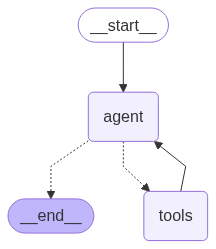

In [9]:
from deepagents import create_deep_agent

agent = create_deep_agent(
    sub_agent_tools,
    INSTRUCTIONS,
    subagents=[research_sub_agent],
    model=model,
)

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "Give me an overview of Model Context Protocol (MCP).",
            }
        ],
    }
)

format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Give me an overview of Model Context Protocol (MCP).                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I'll help you get a comprehensive overview of Model Context Protocol (MCP). Let me start by creating a research │
│ plan and then gather information about this topic.                                                              │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Save user request to file system for reference",                                              │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research Model Context Protocol (MCP) - definition, purpose, key features, and current        │
│ status",                                                                                                        │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Analyze research findings and provide comprehensive overview to user",                        │
│       "status": "pending"                                                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: toolu_01Vt4DTBphqx14Fg1TRMWmiD                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Save user request to file system for reference', 'status': 'pending'},       │
│ {'content': 'Research Model Context Protocol (MCP) - definition, purpose, key features, and current status',    │
│ 'status': 'pending'}, {'content': 'Analyze research findings and provide comprehensive overview to user',       │
│ 'status': 'pending'}]                                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: ls                                                                                                │
│    Args: {}                                                                                                     │
│    ID: toolu_019etjNwQZxtxGbwd9z83won                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Save user request to file system for reference",                                              │
│       "status": "in_progress"                                                                                   │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research Model Context Protocol (MCP) - definition, purpose, key features, and current        │
│ status",                                                                                                        │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Analyze research findings and provide comprehensive overview to user",                        │
│       "status": "pending"                                                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: toolu_01YMJsvK9QLhw44dYgHr8jEK                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Save user request to file system for reference', 'status': 'in_progress'},   │
│ {'content': 'Research Model Context Protocol (MCP) - definition, purpose, key features, and current status',    │
│ 'status': 'pending'}, {'content': 'Analyze research findings and provide comprehensive overview to user',       │
│ 'status': 'pending'}]                                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_file                                                                                        │
│    Args: {                                                                                                      │
│   "file_path": "user_request.md",                                                                               │
│   "content": "# User Request\n\nGive me an overview of Model Context Protocol (MCP).\n\n## Research             │
│ Goal\nProvide a comprehensive overview covering:\n- What MCP is\n- Its purpose and objectives\n- Key features   │
│ and capabilities\n- Current status and adoption\n- Technical details and architecture\n- Use cases and          │
│ applications"                                                                                                   │
│ }                                                                                                               │
│    ID: toolu_018V9WMfDuZj9pP7fXLSfrFC                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated file user_request.md                                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Save user request to file system for reference",                                              │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research Model Context Protocol (MCP) - definition, purpose, key features, and current        │
│ status",                                                                                                        │
│       "status": "in_progress"                                                                                   │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Analyze research findings and provide comprehensive overview to user",                        │
│       "status": "pending"                                                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: toolu_016pKzt8S87ThY64fM2SdtAK                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Save user request to file system for reference', 'status': 'completed'},     │
│ {'content': 'Research Model Context Protocol (MCP) - definition, purpose, key features, and current status',    │
│ 'status': 'in_progress'}, {'content': 'Analyze research findings and provide comprehensive overview to user',   │
│ 'status': 'pending'}]                                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Now let me delegate the research task to gather comprehensive information about Model Context Protocol.         │
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "description": "Research Model Context Protocol (MCP) comprehensively. I need you to find and gather          │
│ information about:\n\n1. What MCP is - definition and core concept\n2. Who developed it and when\n3. The main   │
│ purpose and objectives of MCP\n4. Key technical features and capabilities\n5. How it works - architecture and   │
│ implementation details\n6. Current status - is it released, in development, or proposed?\n7. Use cases and      │
│ practical applications\n8. Any notable adopters or implementations\n9. Comparison to similar protocols or       │
│ standards\n10. Future roadmap or development plans\n\nPlease search for official documentation, announcements,  │
│ technical specifications, and credible sources. Save your findings in a detailed markdown file that I can       │
│ reference to provide a comprehensive overview to the user.",                                                    │
│   "subagent_type": "research-agent"                                                                             │
│ }                                                                                                               │
│    ID: toolu_01BeKxWykKf9ihn1i1H5vjjE                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Based on my comprehensive research, I've gathered extensive information about the Model Context Protocol (MCP). │
│ Here's what I found:                                                                                            │
│                                                                                                                 │
│ ## Research Summary: Model Context Protocol (MCP)                                                               │
│                                                                                                                 │
│ ### 1. **What MCP Is - Definition and Core Concept**                                                            │
│ The Model Context Protocol (MCP) is an open standard and framework designed to facilitate integration between   │
│ AI systems (particularly large language models) and external data sources and tools. It acts as a universal     │
│ interface - often described as a "USB-C port for AI functionalities" - that standardizes how AI applications    │
│ connect to various systems.                                                                                     │
│                                                                                                                 │
│ ### 2. **Developer and Timeline**                                                                               │
│ - **Developer**: Anthropic                                                                                      │
│ - **Release Date**: November 2024                                                                               │
│ - **Type**: Open-source framework and open standard                                                             │
│                                                                                                                 │
│ ### 3. **Main Purpose and Objectives**                                                                          │
│ MCP addresses the critical "N×M integration problem" in AI systems by:                                          │
│ - Eliminating the complexity of custom integrations                                                             │
│ - Providing standardized methods for AI engineers to connect various tools and systems                          │
│ - Breaking down data silos that limit AI functionality                                                          │
│ - Enabling AI systems to access real-time, live data beyond their static training data                          │
│                                                                                                                 │
│ ### 4. **Key Technical Features and Capabilities**                                                              │
│ - **Client-server architecture** with hosts, clients, and servers for efficient communication                   │
│ - **Secure, bidirectional connections** for data exchange                                                       │
│ - **Standardized two-way communication** between AI models and external systems                                 │
│ - **Real-time data access** capabilities                                                                        │
│ - **Universal interface** that works across different AI systems and data sources                               │
│ - **Scalable integration** that reduces the need for custom point-to-point connections                          │
│                                                                                                                 │
│ ### 5. **Architecture and Implementation**                                                                      │
│ MCP uses a client-server model where:                                                                           │
│ - **Hosts**: AI applications that need to access extern

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: think_tool                                                                                        │
│    Args: {                                                                                                      │
│   "reflection": "The research agent has provided excellent comprehensive information about Model Context        │
│ Protocol (MCP). The findings cover all the key aspects I was looking for:\n\n1. Clear definition - MCP is an    │
│ open standard by Anthropic for AI-external system integration\n2. Recent development - Released in November     │
│ 2024, so very current\n3. Strong industry adoption - Major players like OpenAI, Google DeepMind, Microsoft      │
│ adopting it\n4. Technical architecture - Client-server model with standardized communication\n5. Practical      │
│ impact - Solving the N\u00d7M integration problem in AI systems\n6. Current status - Released and rapidly       │
│ growing (1000+ servers created)\n\nThe information appears comprehensive and from credible sources. I have      │
│ enough detail to provide the user with a thorough overview of MCP. The research covers both technical aspects   │
│ and business/industry context, which gives a complete picture.\n\nI should now move to the final task of        │
│ analyzing these findings and presenting them to the user in a clear, organized manner."                         │
│ }                                                                                                               │
│    ID: toolu_011g95gfRSkkJd3j1N5fT5ue                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Reflection recorded: The research agent has provided excellent comprehensive information about Model Context    │
│ Protocol (MCP). The findings cover all the key aspects I was looking for:                                       │
│                                                                                                                 │
│ 1. Clear definition - MCP is an open standard by Anthropic for AI-external system integration                   │
│ 2. Recent development - Released in November 2024, so very current                                              │
│ 3. Strong industry adoption - Major players like OpenAI, Google DeepMind, Microsoft adopting it                 │
│ 4. Technical architecture - Client-server model with standardized communication                                 │
│ 5. Practical impact - Solving the N×M integration problem in AI systems                                         │
│ 6. Current status - Released and rapidly growing (1000+ servers created)                                        │
│                                                                                                                 │
│ The information appears comprehensive and from credible sources. I have enough detail to provide the user with  │
│ a thorough overview of MCP. The research covers both technical aspects and business/industry context, which     │
│ gives a complete picture.                                                                                       │
│                                                                                                                 │
│ I should now move to the final task of analyzing these findings and presenting them to the user in a clear,     │
│ organized manner.                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Save user request to file system for reference",                                              │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research Model Context Protocol (MCP) - definition, purpose, key features, and current        │
│ status",                                                                                                        │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Analyze research findings and provide comprehensive overview to user",                        │
│       "status": "in_progress"                                                                                   │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: toolu_015rqpu8jZy27d5D6LiimwdU                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Save user request to file system for reference', 'status': 'completed'},     │
│ {'content': 'Research Model Context Protocol (MCP) - definition, purpose, key features, and current status',    │
│ 'status': 'completed'}, {'content': 'Analyze research findings and provide comprehensive overview to user',     │
│ 'status': 'in_progress'}]                                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ # Model Context Protocol (MCP) Overview                                                                         │
│                                                                                                                 │
│ ## What is MCP?                                                                                                 │
│                                                                                                                 │
│ The **Model Context Protocol (MCP)** is an open standard and framework developed by **Anthropic** and released  │
│ in **November 2024**. It's designed to solve a critical challenge in AI systems: how to efficiently connect AI  │
│ applications (particularly large language models) with external data sources and tools.                         │
│                                                                                                                 │
│ Think of MCP as a "USB-C port for AI functionalities" - it provides a universal interface that standardizes how │
│ AI systems integrate with various external resources.                                                           │
│                                                                                                                 │
│ ## The Problem MCP Solves                                                                                       │
│                                                                                                                 │
│ Before MCP, AI systems faced the **"N×M integration problem"**:                                                 │
│ - Every AI application needed custom integrations with each external tool or data source                        │
│ - This created a complex web of point-to-point connections                                                      │
│ - Data silos limited AI functionality to static training data                                                   │
│ - Integration complexity slowed development and innovation                                                      │
│                                                                                                                 │
│ ## Key Features & Architecture                                                                                  │
│                                                                                                                 │
│ MCP uses a **client-server architecture** with three main components:                                           │
│                                                                                                                 │
│ - **Hosts**: AI applications that need external resources                                                       │
│ - **Clients**: Components that initiate connections and requests                                                │
│ - **Servers**: External systems providing data, tools, or services                                              │
│                                                                                                                 │
│ The protocol enables:                                                                                           │
│ - ✅ **Secure, bidirectional communication**                                                                    │
│ - ✅ **Real-time data access** beyond static training data                                                      │
│ - ✅ **Standardized integration** across different systems                                                      │
│ - ✅ **Scalable connectivity** without custom point-to-point solutions                                          │
│                                                                                                                 │
│ ## Industry Adoption & Impact                              

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Save user request to file system for reference', 'status': 'completed'},     │
│ {'content': 'Research Model Context Protocol (MCP) - definition, purpose, key features, and current status',    │
│ 'status': 'completed'}, {'content': 'Analyze research findings and provide comprehensive overview to user',     │
│ 'status': 'completed'}]                                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Trace: 

https://smith.langchain.com/public/1ae2d7f6-f901-4ebd-b6c3-6657a55f88ae/r